In [1]:
import sys
sys.path.append('../scripts/')
from robot import *
from scipy.stats import multivariate_normal
from matplotlib.patches import Ellipse

In [2]:
def sigma_ellipse(p, cov, n): ###kf2threesigma
    eig_vals, eig_vec = np.linalg.eig(cov)
    ang = math.atan2(eig_vec[:,0][1], eig_vec[:,0][0])/math.pi*180
    return Ellipse(p, width=n*math.sqrt(eig_vals[0]),height=n*math.sqrt(eig_vals[1]), angle=ang, fill=False, color="blue", alpha=0.5)

In [3]:
class KalmanFilter:   ###kfmotionupdate
    def __init__(self, envmap, init_pose, motion_noise_stds={"nn":0.19, "no":0.001, "on":0.13, "oo":0.2}):
        self.belief = multivariate_normal(mean=np.array([0.0, 0.0, 0.0]), 
                                        cov=np.diag([1e-10, 1e-10, 1e-10]))
        self.motion_noise_stds = motion_noise_stds #追加
        
    def motion_update(self, nu, omega, time): #追加
        if abs(omega) < 1e-5: omega = 1e-5
        if abs(nu) < 1e-5:         nu = 1e-5

        v = self.motion_noise_stds
        M = np.diag([v["nn"]**2*abs(nu)/time + v["no"]**2*abs(omega)/time, 
                     v["on"]**2*abs(nu)/time + v["oo"]**2*abs(omega)/time])
        
        t = self.belief.mean[2]
        st, ct = math.sin(t), math.cos(t)
        stw, ctw = math.sin(t + omega*time), math.cos(t + omega*time)
        A = np.array([[(stw - st)/omega,    -nu/(omega**2)*(stw - st) + nu/omega*time*ctw],
                                 [(-ctw + ct)/omega, -nu/(omega**2)*(-ctw + ct) + nu/omega*time*stw],
                                 [0,                                time]] )
        
        F = np.diag([1.0, 1.0, 1.0])
        F[0, 2] = nu / omega * (math.cos(t + omega * time) - math.cos(t))
        F[1, 2] = nu / omega * (math.sin(t + omega * time) - math.sin(t))
            
        self.belief.cov = F.dot(self.belief.cov).dot(F.T) + A.dot(M).dot(A.T)
        self.belief.mean = IdealRobot.state_transition(nu, omega, time, self.belief.mean)

    def draw(self, ax, elems):
        ###xy平面上の誤差のnシグマ範囲###
        e = sigma_ellipse(self.belief.mean[0:2], self.belief.cov[0:2, 0:2], 3)
        elems.append(ax.add_patch(e))

        ###θ方向の誤差の3シグマ範囲###
        x, y, c = self.belief.mean
        sigma3 = math.sqrt(self.belief.cov[2, 2])*3
        xs = [x + math.cos(c-sigma3), x, x + math.cos(c+sigma3)]
        ys = [y + math.sin(c-sigma3), y, y + math.sin(c+sigma3)]
        elems += ax.plot(xs, ys, color="blue", alpha=0.5)

In [4]:
class KfAgent(Agent):  
    def __init__(self, time_interval, nu, omega, kf):
        super().__init__(nu, omega)
        self.kf = kf
        self.time_interval = time_interval
        
        self.prev_nu = 0.0 
        self.prev_omega = 0.0
        
    def decision(self, observation=None):
        self.kf.motion_update(self.prev_nu, self.prev_omega, self.time_interval) #書き換え
        self.prev_nu, self.prev_omega = self.nu, self.omega
        
        return self.nu, self.omega
        
    def draw(self, ax, elems): #追加
        self.kf.draw(ax, elems)

<IPython.core.display.Javascript object>


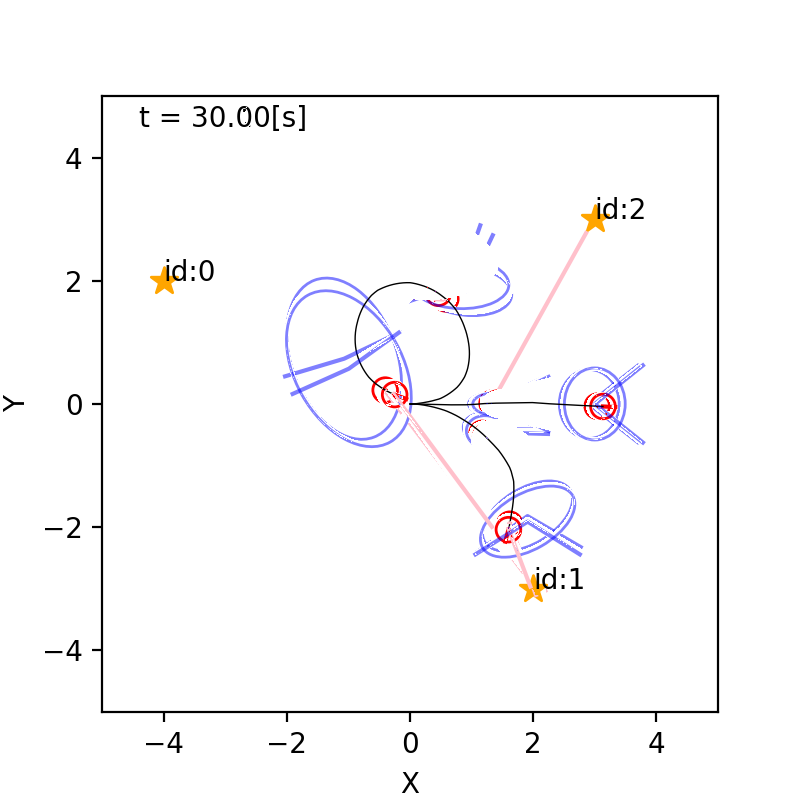

In [5]:
if __name__ == '__main__': 
    time_interval = 0.1
    world = World(30, time_interval, debug=False) 

    ### 地図を生成して3つランドマークを追加 ###
    m = Map()                                  
    m.append_landmark(Landmark(-4,2))
    m.append_landmark(Landmark(2,-3))
    m.append_landmark(Landmark(3,3))
    world.append(m)          

    ### ロボットを作る ###
    initial_pose = np.array([0, 0, 0]).T
    kf = KalmanFilter(m, initial_pose)
    circling = KfAgent(time_interval, 0.2, 10.0/180*math.pi, kf)
    r = Robot(initial_pose, sensor=Camera(m), agent=circling, color="red")
    world.append(r)
    
    kf = KalmanFilter(m, initial_pose)
    linear = KfAgent(time_interval, 0.1, 0.0, kf)
    r = Robot(initial_pose, sensor=Camera(m), agent=linear, color="red")
    world.append(r)
    
    kf = KalmanFilter(m, initial_pose)
    right = KfAgent(time_interval, 0.1, -3.0/180*math.pi, kf)
    r = Robot(initial_pose, sensor=Camera(m), agent=right, color="red")
    world.append(r)

    world.draw()